# **Detección de estados de ánimo a través de sensores**
-----
## **Notebook 3**

### Aboulafia Gerardo, Barquet Amélie, Lombardo Micaela, Lopez Verónica, Vazquez Agustina
##### Laboratorio: Consultoría de Datos

El objetivo de esta notebook es analizar los distintos pacientes en búsqueda de outliers en las variables. En caso de ser así, los mismos serán tratados. Además se harán implementaciones de distintos modelos, un random forest como modelo base y un XG boost como segundo modelo con ajustes y se comparará su desempeño.

# 0. Importe de librerías y carga de datos

In [69]:
# Librerías estándar
import pickle

# Ciencia de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Estadística
from scipy.stats import skew, kurtosis
from scipy.stats.mstats import winsorize

# Machine Learning / Preprocesamiento
from sklearn.preprocessing import StandardScaler
import json, joblib, numpy as np, pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import warnings, pandas as pd, numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier

# Funciones personalizadas
from exploracion import extract_float, porcentaje_outliers

In [70]:
# Carga del dataset
df = pd.read_csv(r"C:\Users\mical\OneDrive - UCA\UCA\2025\1er cuatrimestre\Laboratorio de datos I\df_final.csv")
df = df[df['Label'].isin([1,2])]

df.columns

Index(['acc_mean', 'acc_std', 'acc_maxx', 'acc_maxy', 'acc_maxz', 'eda_max',
       'eda_min', 'eda_mean', 'eda_range', 'eda_std', 'eda_slope', 'tmp_max',
       'tmp_min', 'tmp_mean', 'tmp_range', 'tmp_std', 'Label', 'Paciente',
       'Age', 'Height', 'Weight', 'Gender', 'Dominant hand'],
      dtype='object')

In [71]:
df["Paciente"].unique()

array(['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4',
       'S5', 'S6', 'S7', 'S8', 'S9'], dtype=object)

In [72]:
# Estilo
sns.set(style="whitegrid")

# 1. Exploración de datos inicial

### Exploramos las medias de las variables

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\257522158.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


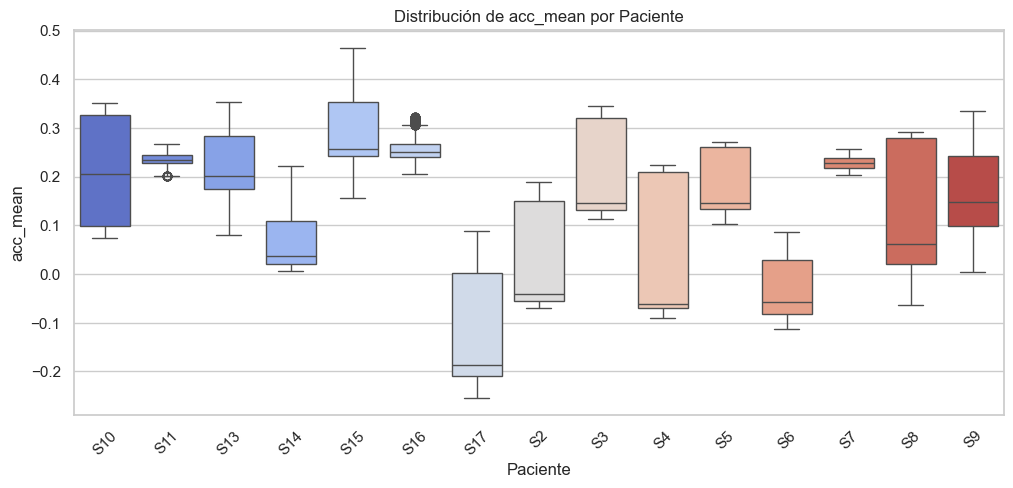

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\257522158.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


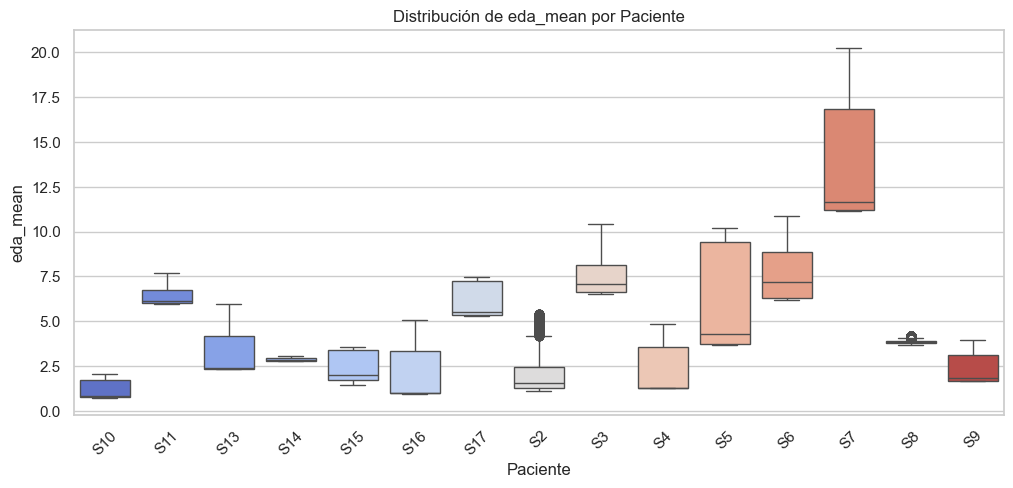

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\257522158.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


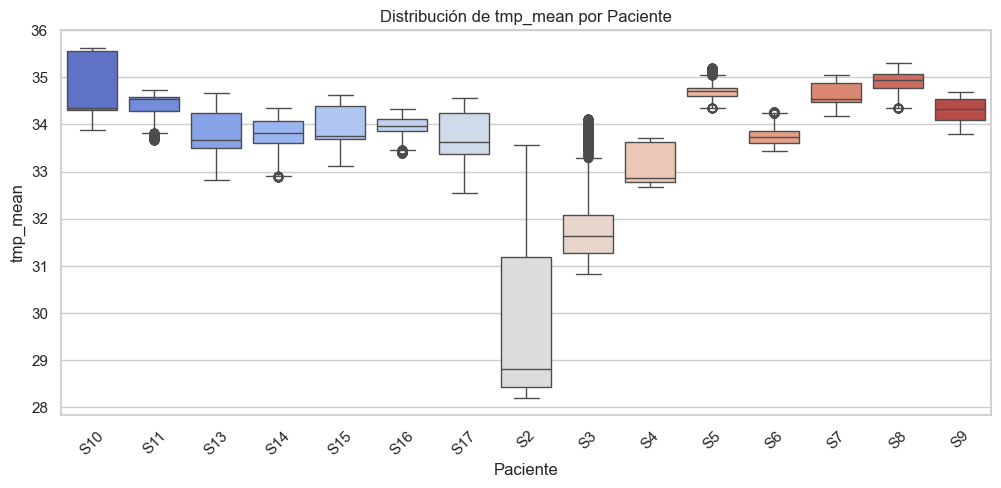

In [73]:
vars_means = ['acc_mean', 'eda_mean', 'tmp_mean']
for var in vars_means:
    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')
    plt.title(f"Distribución de {var} por Paciente")
    plt.xticks(rotation=45)
    plt.show()

Viuslizamos los boxplots por pacientes de las variables acc_mean, eda_mean y tmp_mean. En acc no se oberva ningun paciente "outlier" claro, mientras que en eda podemos ver que el paciente 7 se distingue significativamente de los demás, así como el paciente 2 en la temperatura. De igual manera, este último tiene sentido porque en las notas de paciente se aclaraba que el termotetro del paciente 2 funcionaba de manera defectuosa.

### Exploramos los máximos de las variables

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\3452713984.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


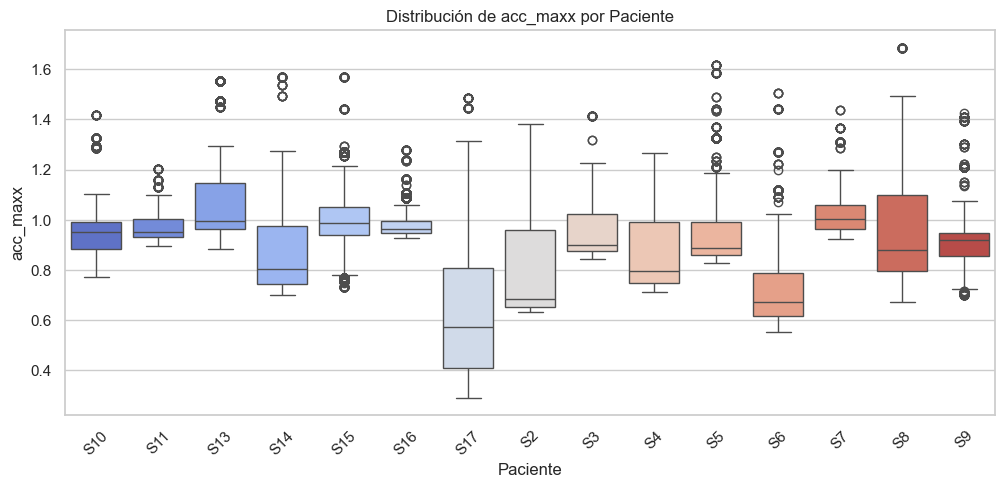

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\3452713984.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


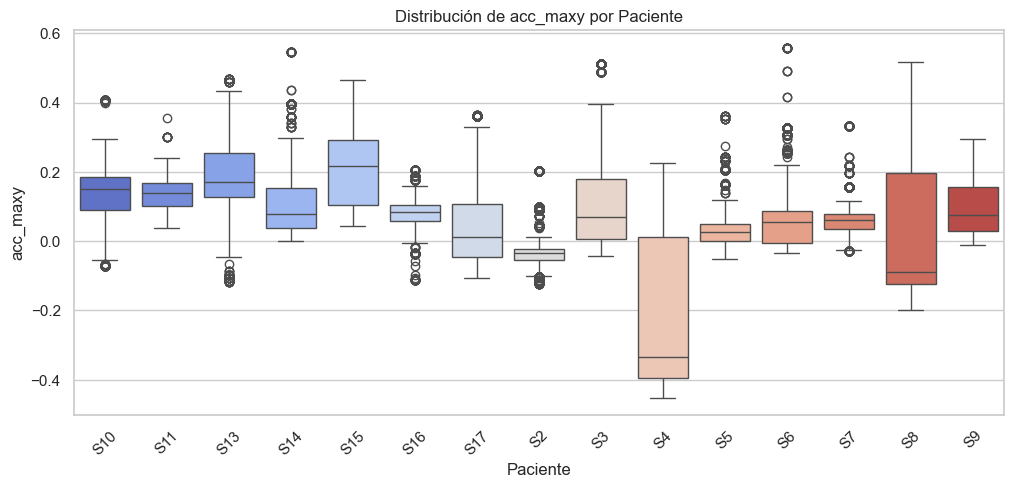

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\3452713984.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


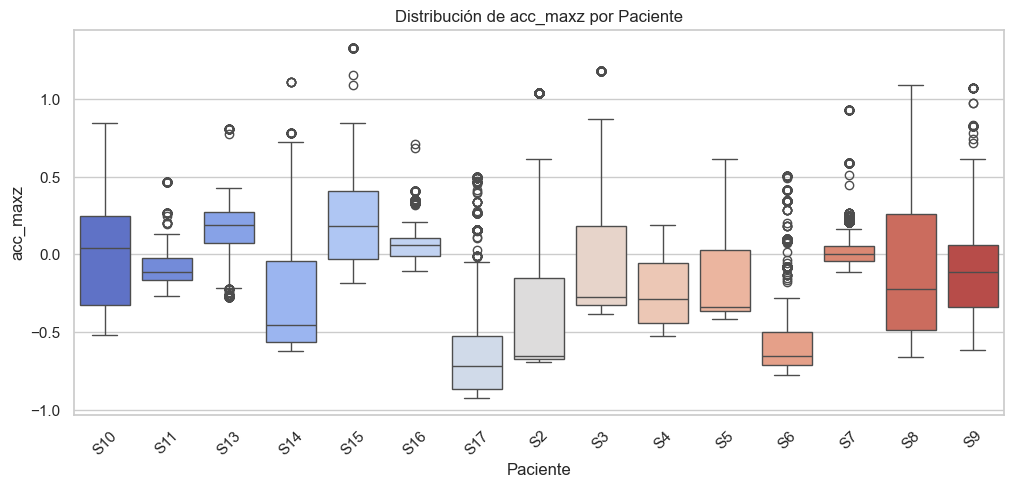

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\3452713984.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


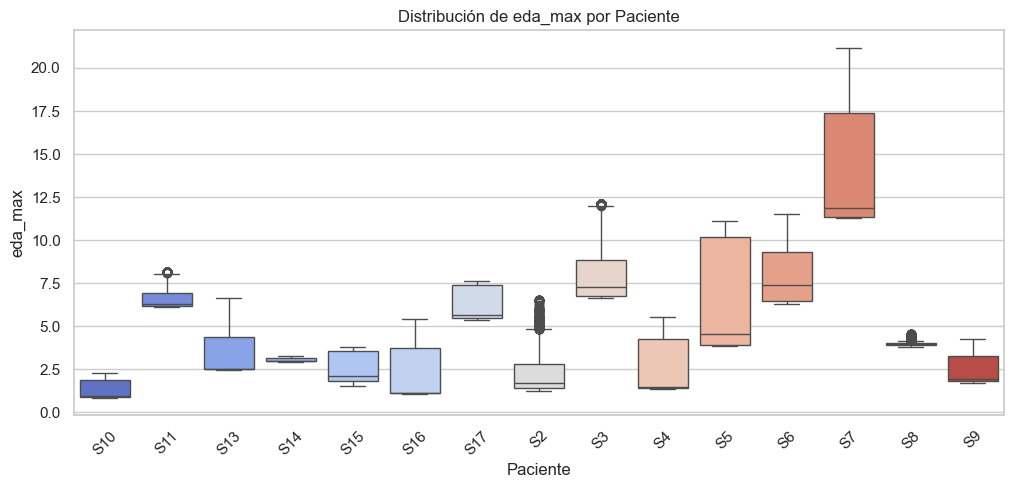

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\3452713984.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


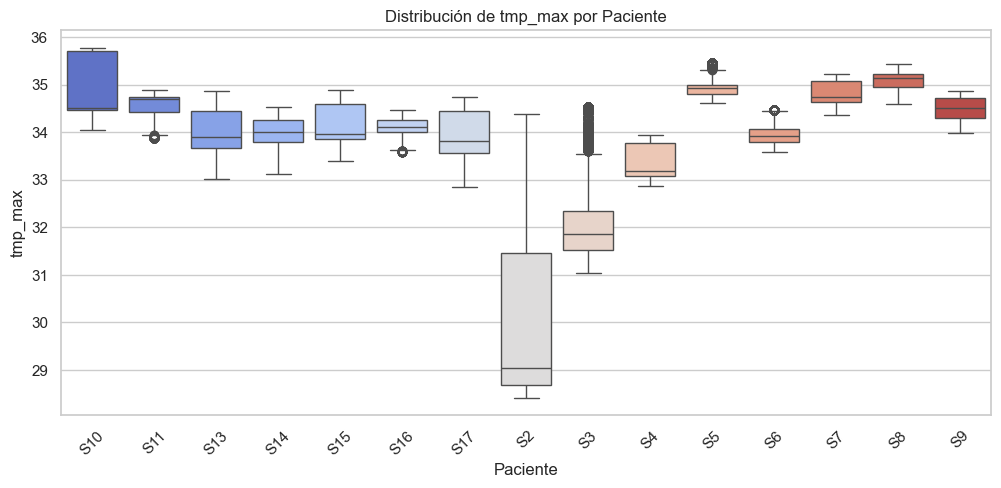

In [74]:
vars_max = ['acc_maxx', 'acc_maxy', 'acc_maxz', 'eda_max', 'tmp_max']
for var in vars_max:
    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')
    plt.title(f"Distribución de {var} por Paciente")
    plt.xticks(rotation=45)
    plt.show()

Las observaciones se mantienen cohesivas con lo concluido anteriormente, el paciente 2 en temperatura se presenta como outlier así como el paciente 7 para el EDA.

### Exploramos los desvíos estándar de las variables

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\3996174158.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


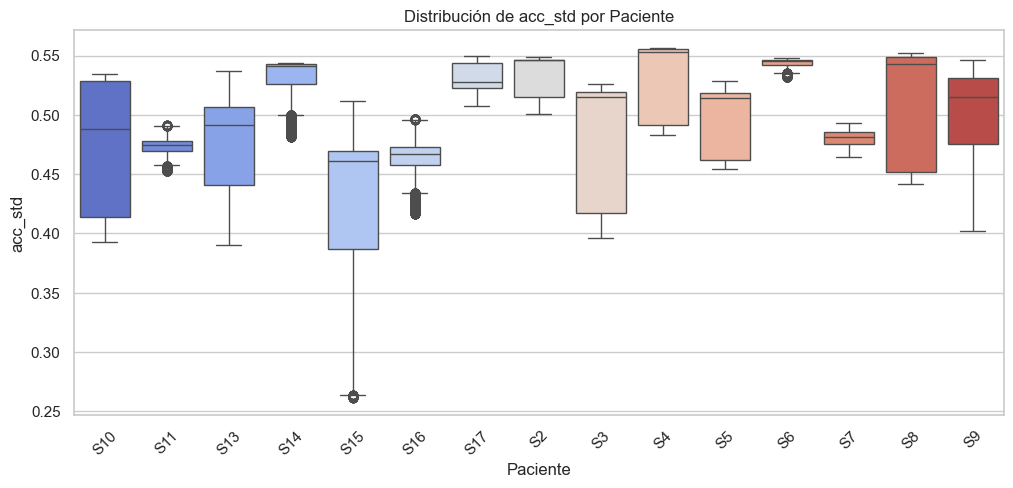

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\3996174158.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


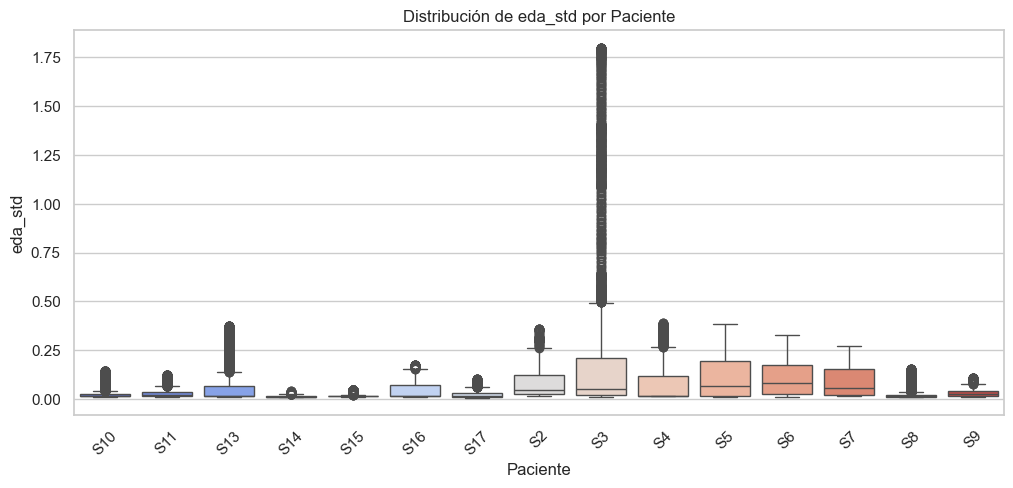

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\3996174158.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


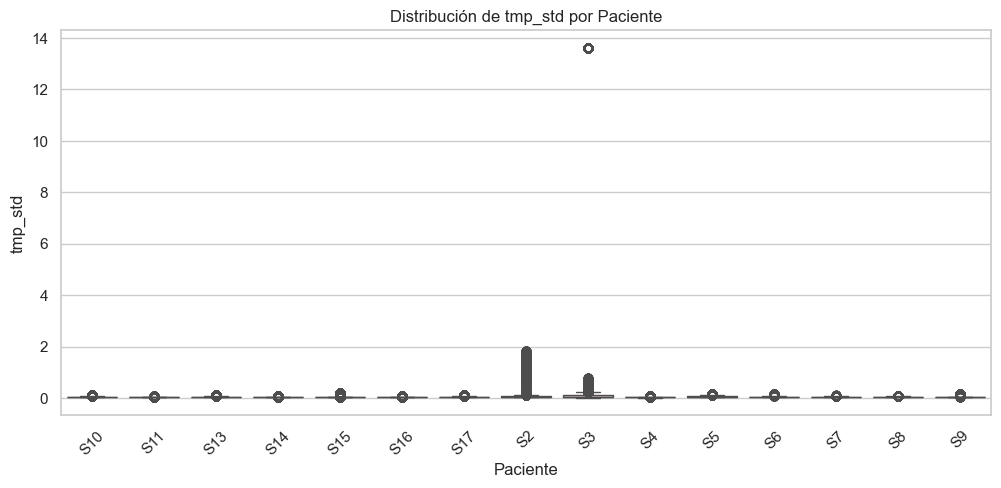

In [75]:
vars_std = ['acc_std', 'eda_std', 'tmp_std']
for var in vars_std:
    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')
    plt.title(f"Distribución de {var} por Paciente")
    plt.xticks(rotation=45)
    plt.show()

En esta sección se analiza el desvío estándar de las 3 variables. En el de la temperatura, el paciente 3 presenta un outlier bastante extremo y en el EDA, el mismo paciente muestra una gran cantidad de outliers.

### Exploramos los mínimos de las variables

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\4080338578.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


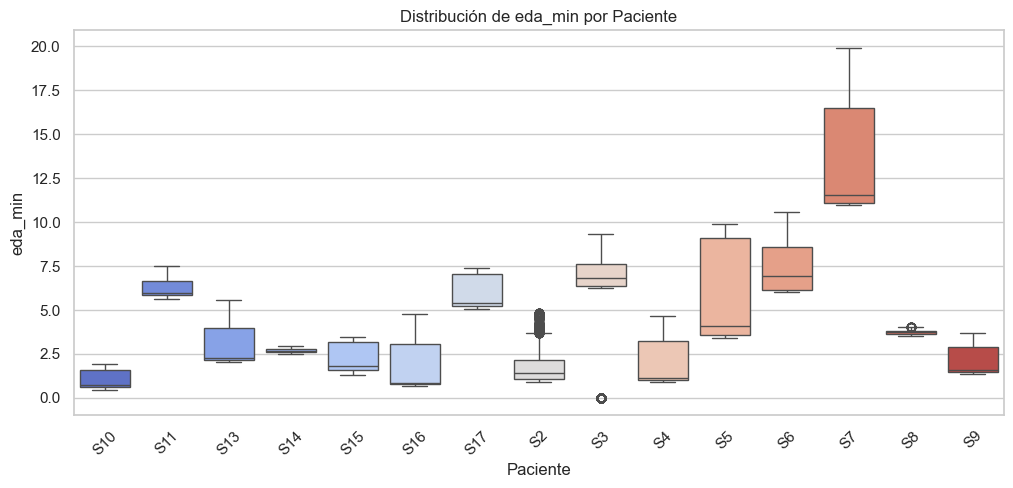

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\4080338578.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


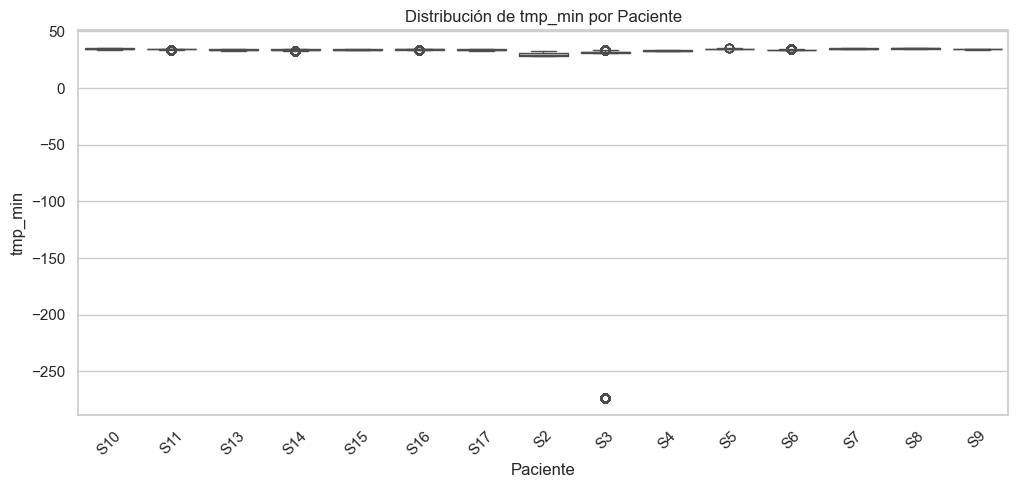

In [76]:
vars_minimas = ['eda_min', 'tmp_min']
for var in vars_minimas:
    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')
    plt.title(f"Distribución de {var} por Paciente")
    plt.xticks(rotation=45)
    plt.show()

Analizamos los minimos del EDA y de temperatura. Una vez más, el paciente 7 se muestra como outlier. Además se puede ver un outlier (error de medición) en la temperatura del paciente 3, en donde la medición ronda en -250 grados, algo físicamente imposible para un humano.

### Exploramos demás variables

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\3855385515.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


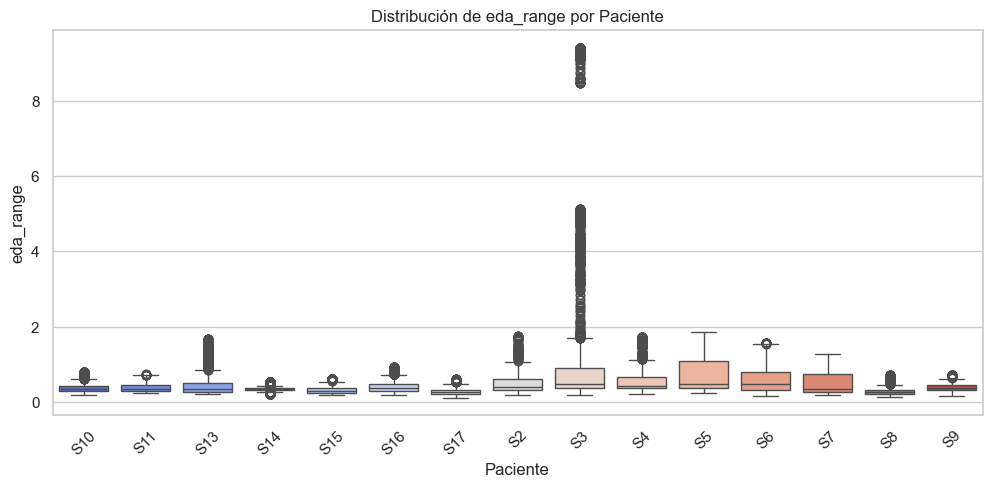

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\3855385515.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')


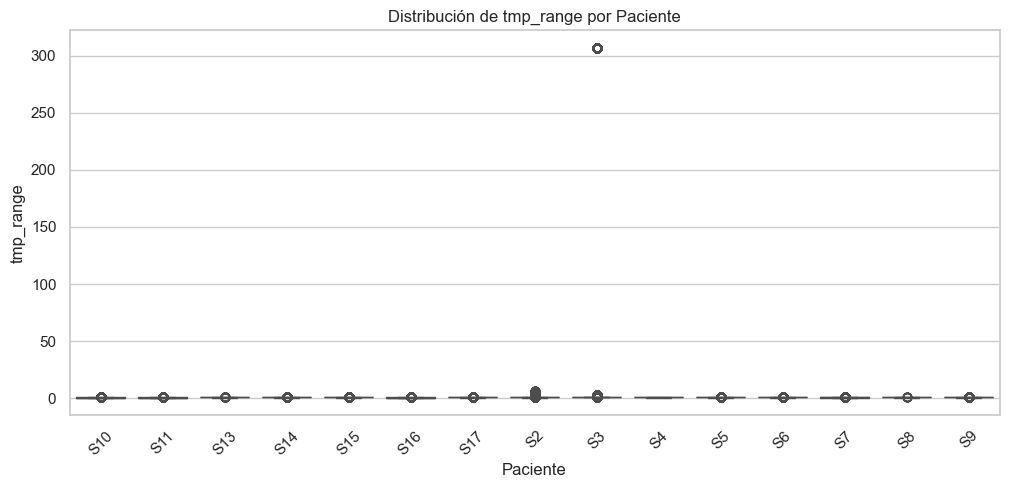

In [77]:
vars_extras = ['eda_range', 'tmp_range']
for var in vars_extras:
    plt.figure(figsize=(12,5))
    sns.boxplot(data=df, x='Paciente', y=var, palette='coolwarm')
    plt.title(f"Distribución de {var} por Paciente")
    plt.xticks(rotation=45)
    plt.show()

Se puede ver como el paciente 3 es el que más valores extremos presenta, incluso errores, más especificamente en el boxplot de temperaturas, en donde se puede ver una observación cercana a los 300 grados, algo imposible para un ser humano.

# 2. Desarrollo por paciente

Ahora que ya identificamos qué pacientes se presentan como outliers y en qué variables, decidimos hacer un análisis más específico de estas para poder realizar una limpieza. Se analiza el EDA para el paciente 7, y temperatura para el paciente 2.

### Paciente 7

In [78]:
paciente_7 = df[df['Paciente'] == 'S7']

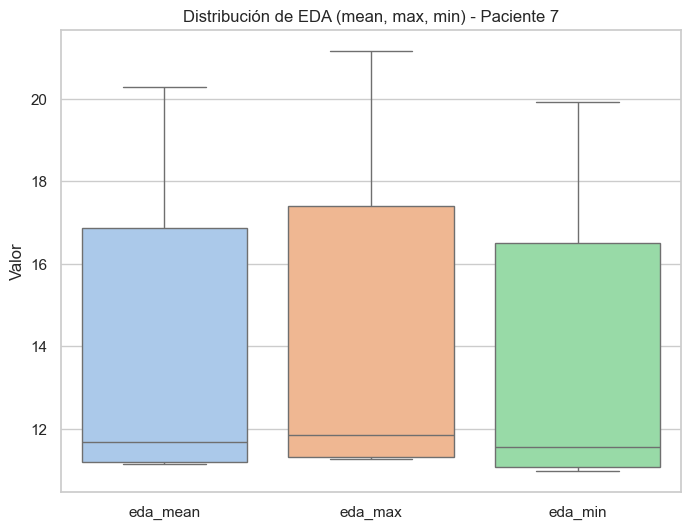

In [79]:
plt.figure(figsize=(8,6))
sns.boxplot(data=paciente_7[['eda_mean', 'eda_max', 'eda_min']], palette="pastel")
plt.title("Distribución de EDA (mean, max, min) - Paciente 7")
plt.ylabel("Valor")
plt.show()

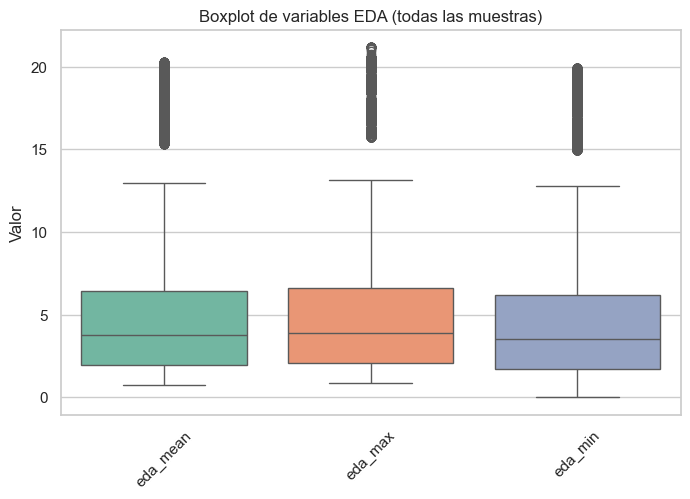

In [80]:
eda_vars = ['eda_mean','eda_max','eda_min']

plt.figure(figsize=(8,5))
sns.boxplot(data=df[eda_vars], palette="Set2")
plt.title("Boxplot de variables EDA (todas las muestras)")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.show()

Las observaciones del paciente 7 son notablemente más altas en comparación con el resto de los pacientes. Mientras que los cuartiles de la mayoría de los pacientes se encuentran aproximadamente entre 2 y 6, en el caso del paciente 7 se ubican en valores considerablemente mayores, cercanos a 12 y 17. Esto indica que sus mediciones se sitúan en un rango claramente diferente a los del resto.

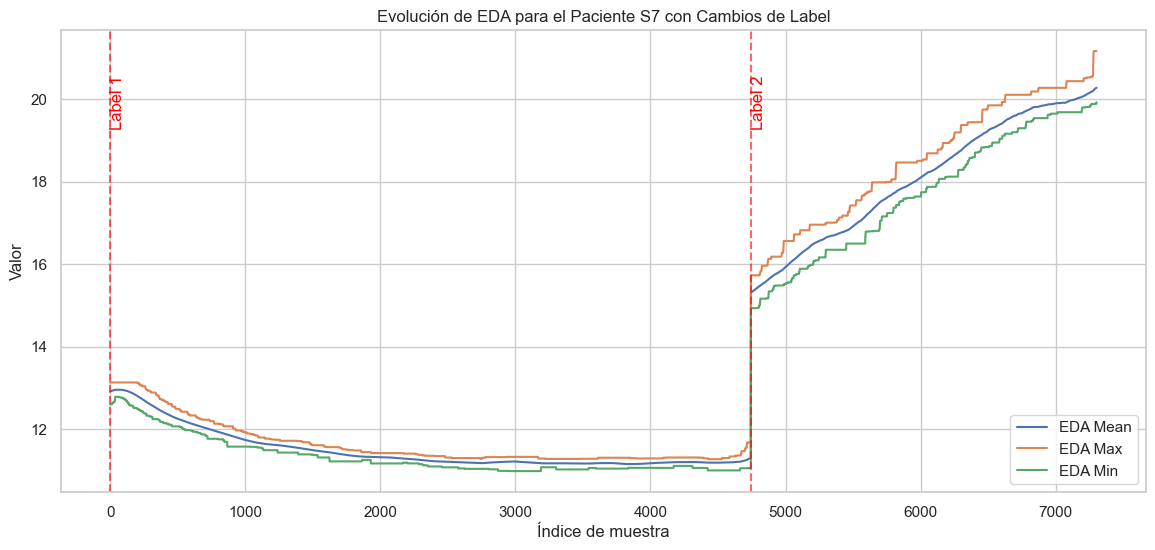

In [81]:
# Resetear el índice para asegurar correspondencia con las curvas
paciente_7 = paciente_7.reset_index(drop=True)

# Encontrar los índices donde cambia el Label
label_changes = paciente_7['Label'].ne(paciente_7['Label'].shift()).to_numpy().nonzero()[0]

# Graficar EDA
plt.figure(figsize=(14,6))
plt.plot(paciente_7['eda_mean'], label='EDA Mean')
plt.plot(paciente_7['eda_max'], label='EDA Max')
plt.plot(paciente_7['eda_min'], label='EDA Min')

# Marcar los cambios de Label
for idx in label_changes:
    plt.axvline(x=idx, color='red', linestyle='--', alpha=0.6)
    plt.text(idx, plt.ylim()[1]*0.95, f"Label {paciente_7.loc[idx, 'Label']}",
             rotation=90, color='red', verticalalignment='top')

plt.title("Evolución de EDA para el Paciente S7 con Cambios de Label")
plt.xlabel("Índice de muestra")
plt.ylabel("Valor")
plt.legend()
plt.show()

Se observa que, al inicio de las pruebas de estrés, el paciente 7 tiene un aumento abrupto en la actividad electrodérmica. Durante el estado de reposo (baseline), la actividad se encuentra bastante estable, con una ligera tendencia descendente. En contraste, cuando comienzan las pruebas de estrés, es claro como la tendencia de la actividad electrodermal es creciente y sostenida, sin presentar descensos, lo que indica una activación fisiológica consistente con una respuesta al estrés.

### Paciente 2

In [82]:
paciente_2 = df[df['Paciente'] == 'S2']

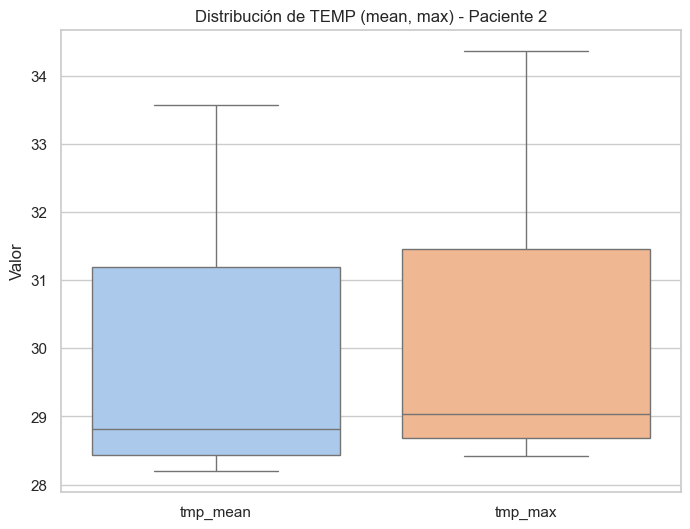

In [83]:
plt.figure(figsize=(8,6))
sns.boxplot(data=paciente_2[['tmp_mean', 'tmp_max']], palette="pastel")
plt.title("Distribución de TEMP (mean, max) - Paciente 2")
plt.ylabel("Valor")
plt.show()

Es claro como las temperaturas registradas del paciente 2 son mucho más bajas a las de una persona normal, tomando valores cercanos a los 30 grados, lo cual confirma que se debe a un error de medición, ya que en la información del paciente se aclaraba que el sensor RespiBAN no estaba del todo bien puesto durante el experimento.

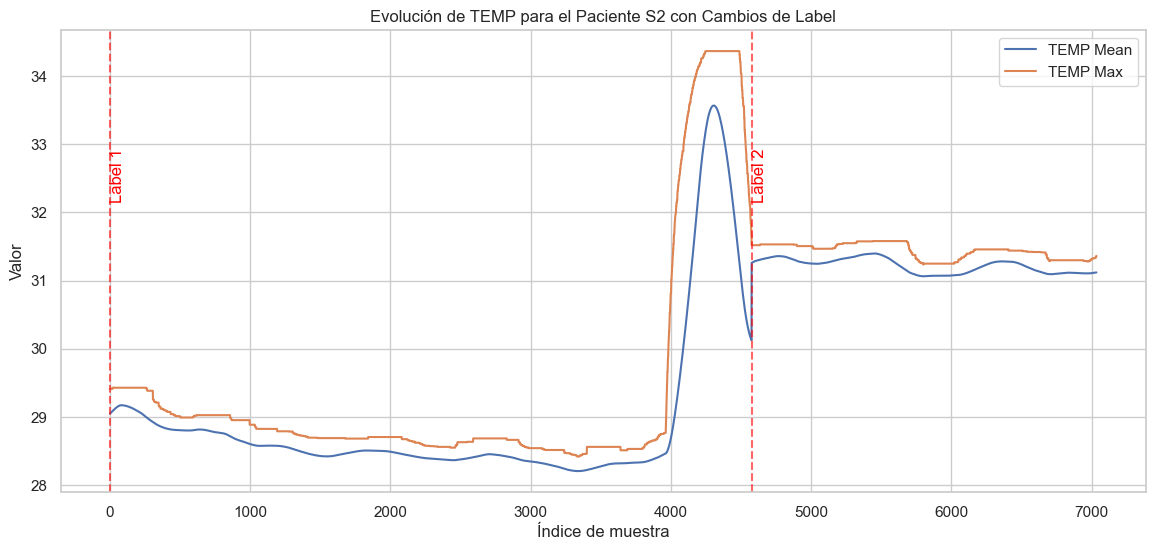

In [84]:
# Resetear el índice para asegurar correspondencia con las curvas
paciente_2 = paciente_2.reset_index(drop=True)

# Encontrar los índices donde cambia el Label
label_changes = paciente_2['Label'].ne(paciente_2['Label'].shift()).to_numpy().nonzero()[0]

# Graficar EDA
plt.figure(figsize=(14,6))
plt.plot(paciente_2['tmp_mean'], label='TEMP Mean')
plt.plot(paciente_2['tmp_max'], label='TEMP Max')

# Marcar los cambios de Label
for idx in label_changes:
    plt.axvline(x=idx, color='red', linestyle='--', alpha=0.6)
    plt.text(idx, plt.ylim()[1]*0.95, f"Label {paciente_2.loc[idx, 'Label']}",
             rotation=90, color='red', verticalalignment='top')

plt.title("Evolución de TEMP para el Paciente S2 con Cambios de Label")
plt.xlabel("Índice de muestra")
plt.ylabel("Valor")
plt.legend()
plt.show()

En la evolución de la temperatura del paciente 2, se observa una disminución progresiva de la señal durante el estado base, con valores de temperatura media y máxima descendiendo levemente. Previo al comienzo de las pruebas de estrés, ambas señales presentan un ascenso abrupto, alcanzando su pico máximo de un poco más de 34 grados. Una vez comenzadas las pruebas, se observa que la temperatura se estabiliza, tomando valores cercanos a los 31 grados, que, de todas formas, son valores bajos para una persona normal y sana, demostrando que se puede deber principalmente a un error de medición.

# 3. Limpieza y normalización de datos

Ya teniendo un análisis más claro de las variables que se presentan con outliers para ciertos pacientes, decidimos realizar un manejo de outliers. Este comienza filtrando los registros con temperaturas medias fuera del rango fisiológico normal (34 a 40 C) y continuamos visualizando el porcentaje de outliers por variable (exluyendo las que no nos interesan).

In [85]:
# Podemos crear una nueva columna que indique el BMI del paciente a partir de las columnas de peso y altura
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# Vemos que la variable tmp_min tiene una correlación de casi -1 con la variable tmp_range y tmp_mean. Por lo tanto, podemos eliminar tmp_min
df = df.drop(columns=['tmp_min'])

# Además, vemos que tmp_range tiene una correlación de 0.99 con tmp_mean, por lo que podemos eliminar tmp_range
df = df.drop(columns=['tmp_range'])

In [86]:
df['eda_slope'] = df['eda_slope'].apply(extract_float)

In [87]:
# Variables que no queremos analizar como numéricas para outliers
excluir = ['Label', 'Paciente', 'Gender', 'Dominant hand', 'Height', 'Weight', 'Age', 'BMI']

# Seleccionar solo columnas numéricas que no estén en la lista de exclusión
variables_numericas = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col not in excluir]

# Ejecutar para todas las variables numéricas seleccionadas
for var in variables_numericas:
    pct = porcentaje_outliers(df, var)
    print(f"{var}: {pct:.2f}% outliers")

acc_mean: 0.00% outliers
acc_std: 0.94% outliers
acc_maxx: 5.53% outliers
acc_maxy: 6.40% outliers
acc_maxz: 0.98% outliers
eda_max: 2.32% outliers
eda_min: 2.32% outliers
eda_mean: 2.32% outliers
eda_range: 10.78% outliers
eda_std: 15.62% outliers
eda_slope: 22.10% outliers
tmp_max: 10.67% outliers
tmp_mean: 10.99% outliers
tmp_std: 9.35% outliers


In [88]:
# Hacemos una copia del df para conservar los valores originales
df_original = df.copy()
df_winsorized = df.copy()

# Columnas a winsorizar
columns_to_winsorize = [
    'acc_std', 'acc_maxx', 'acc_maxy', 'acc_maxz',
    'eda_max', 'eda_min', 'eda_mean', 'eda_range', 'eda_std', 'eda_slope'
]

# Definimos los límites generales de winsorización
limits_default = (0.05, 0.05)  # 5% inferior y 5% superior

# Diccionario para guardar los límites de winsorización por variable
winsorization_limits = {}

# Aplicamos winsorización al train (df_original)
for col in columns_to_winsorize:
    lower = df_original[col].quantile(limits_default[0])
    upper = df_original[col].quantile(1 - limits_default[1])
    winsorization_limits[col] = (lower, upper)

    # Reemplazamos los valores outliers con los límites
    df_winsorized[col] = np.clip(df_original[col], lower, upper)

# Cálculo del porcentaje de valores modificados (outliers)
outlier_percentages = {}

for col in columns_to_winsorize:
    original = df_original[col]
    winsorized = df_winsorized[col]
    outliers = (original != winsorized).sum()
    percentage = (outliers / len(df_original)) * 100
    outlier_percentages[col] = round(percentage, 2)

# Mostramos los resultados
print("Porcentaje de outliers winsorizados por variable:")
for col, pct in outlier_percentages.items():
    print(f"{col}: {pct}%")

Porcentaje de outliers winsorizados por variable:
acc_std: 10.0%
acc_maxx: 9.88%
acc_maxy: 9.86%
acc_maxz: 9.88%
eda_max: 9.92%
eda_min: 9.88%
eda_mean: 10.0%
eda_range: 9.84%
eda_std: 10.0%
eda_slope: 10.0%


In [89]:
print(winsorization_limits)
df_winsorized.columns

{'acc_std': (np.float64(0.4104156549466548), np.float64(0.5509936358834973)), 'acc_maxx': (np.float64(0.6055999994277954), np.float64(1.156599998474121)), 'acc_maxy': (np.float64(-0.1272000074386596), np.float64(0.2793999910354614)), 'acc_maxz': (np.float64(-0.7178000211715698), np.float64(0.4328000545501709)), 'eda_max': (np.float64(1.0807037353515625), np.float64(11.346817016601562)), 'eda_min': (np.float64(0.72784423828125), np.float64(11.060333251953123)), 'eda_mean': (np.float64(0.9621472858247302), np.float64(11.201457081749325)), 'eda_range': (np.float64(0.1995086669921875), np.float64(1.06658935546875)), 'eda_std': (np.float64(0.0103602790874675), np.float64(0.22692213062836078)), 'eda_slope': (np.float64(-9.540402233999999e-06), np.float64(1.0456291439999995e-05))}


Index(['acc_mean', 'acc_std', 'acc_maxx', 'acc_maxy', 'acc_maxz', 'eda_max',
       'eda_min', 'eda_mean', 'eda_range', 'eda_std', 'eda_slope', 'tmp_max',
       'tmp_mean', 'tmp_std', 'Label', 'Paciente', 'Age', 'Height', 'Weight',
       'Gender', 'Dominant hand', 'BMI'],
      dtype='object')

Observamos que está reemplazando correctamente teniendo en cuenta que el máximo a reemplazar puede ser hasta 10% (5% + 5%).

In [90]:
cols = ['tmp_max', 'tmp_mean',  'tmp_std']

# Creamos un DataFrame resumen con las estadísticas para esas columnas
summary_stats = pd.DataFrame({
    'max': df_winsorized[cols].max(),
    'min': df_winsorized[cols].min(),
    'mean': df_winsorized[cols].mean(),
    'median': df_winsorized[cols].median()
})

print(summary_stats)

                max        min       mean     median
tmp_max   35.778046  28.414581  33.918930  34.240480
tmp_mean  35.631836  28.201796  33.706061  34.038887
tmp_std   13.619301   0.014437   0.078148   0.033229


Se aplicó Winsorización a todas las variables, este método reemplaza el outlier por el valor de la siguiente observación más grande o más pequeña dentro del rango definido. Es un proceso simétrico que nos va a ayudar a garantizar que la media siga siendo un estimador robusto. Ahora vamos a continuar haciendo un análisis de las distribuciones después de aplicar el método, viendo si esta distorsiona la distribución original.  

In [91]:
cols_temp = ['tmp_max', 'tmp_mean']

for col in cols_temp:
    df_winsorized[col] = df_winsorized[col].clip(lower=32, upper=40)

In [92]:
# Excluir columnas categóricas o identificadores
cols_no_escalar = ['Label', 'Paciente', 'Gender', 'Dominant hand']
cols_to_scale = df_winsorized.drop(columns=cols_no_escalar).select_dtypes(include='number').columns

# Paso 2: Inicializar el StandardScaler
scaler = StandardScaler()

# Paso 3: Ajustar y transformar los datos numéricos
df_winsorized[cols_to_scale] = scaler.fit_transform(df_winsorized[cols_to_scale])

# Paso 4: Guardar el scaler en un archivo .pkl
with open('scaler_completo.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [93]:
# Guardar scaler como archivo .pkl
with open(r"C:\Users\mical\OneDrive - UCA\UCA\2025\1er cuatrimestre\Laboratorio de datos I\FINAL FINAL\scaler_completo.pkl", "wb") as f:
    pickle.dump(scaler, f)

# 4. Resultados 


 Análisis para 'acc_std':
Media: -0.0
Mediana: 0.218
Asimetría (skewness): -0.539
Curtosis: -0.75


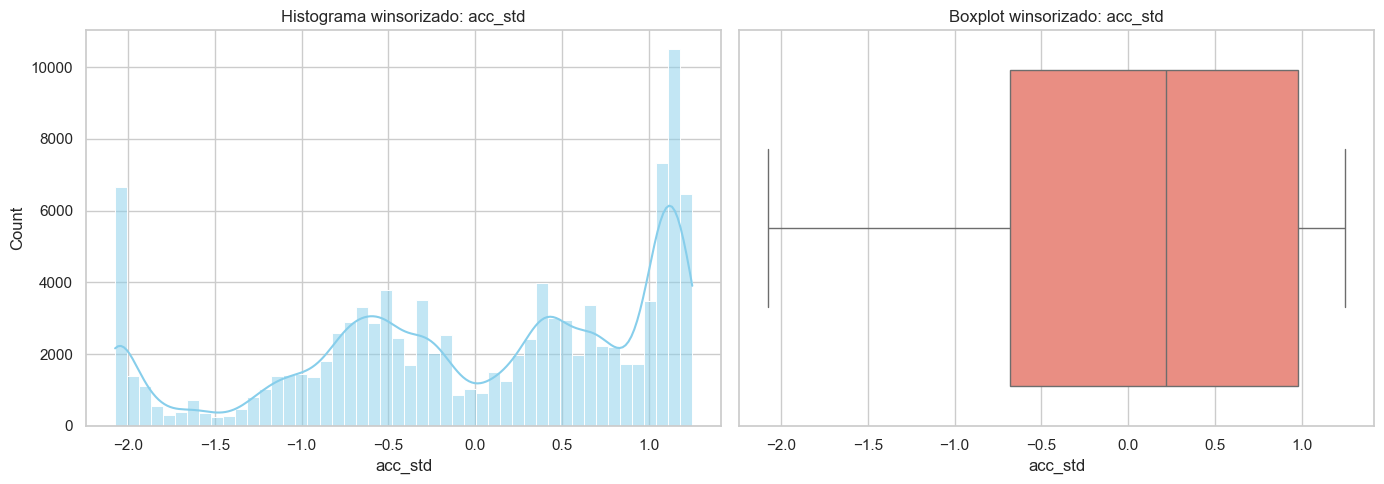


 Análisis para 'acc_maxx':
Media: -0.0
Mediana: 0.22
Asimetría (skewness): -0.457
Curtosis: -0.47


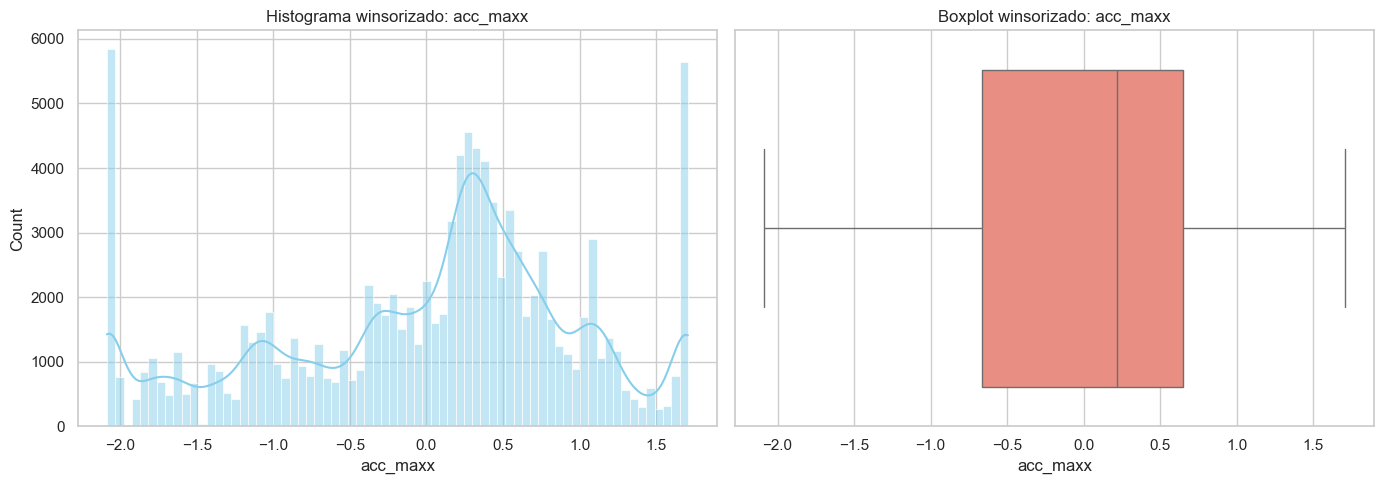


 Análisis para 'acc_maxy':
Media: -0.0
Mediana: -0.014
Asimetría (skewness): 0.039
Curtosis: -0.481


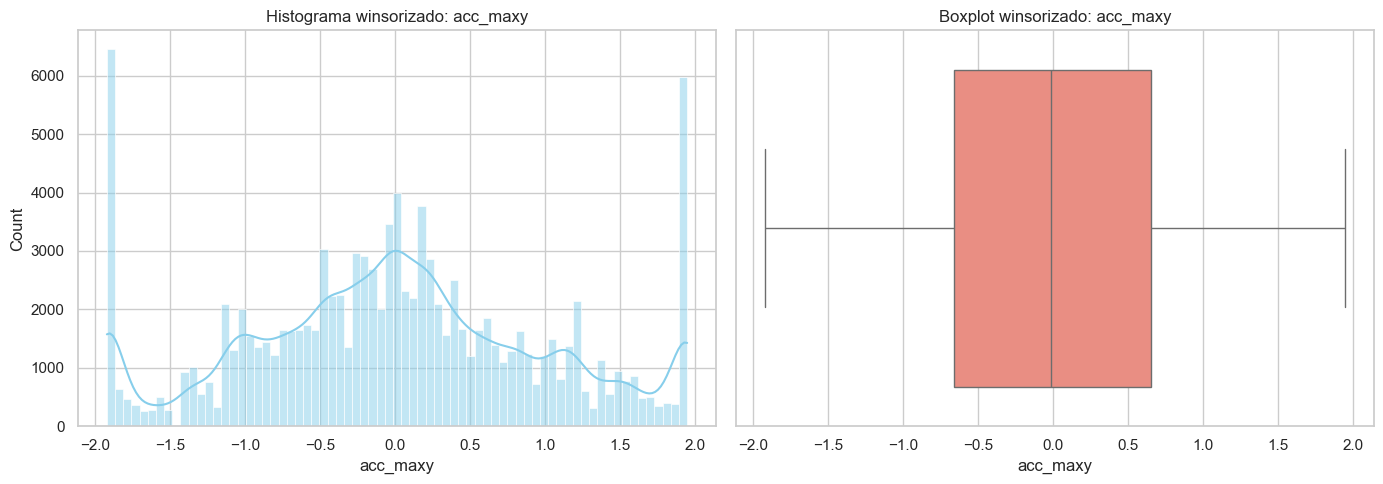


 Análisis para 'acc_maxz':
Media: -0.0
Mediana: 0.193
Asimetría (skewness): -0.117
Curtosis: -0.964


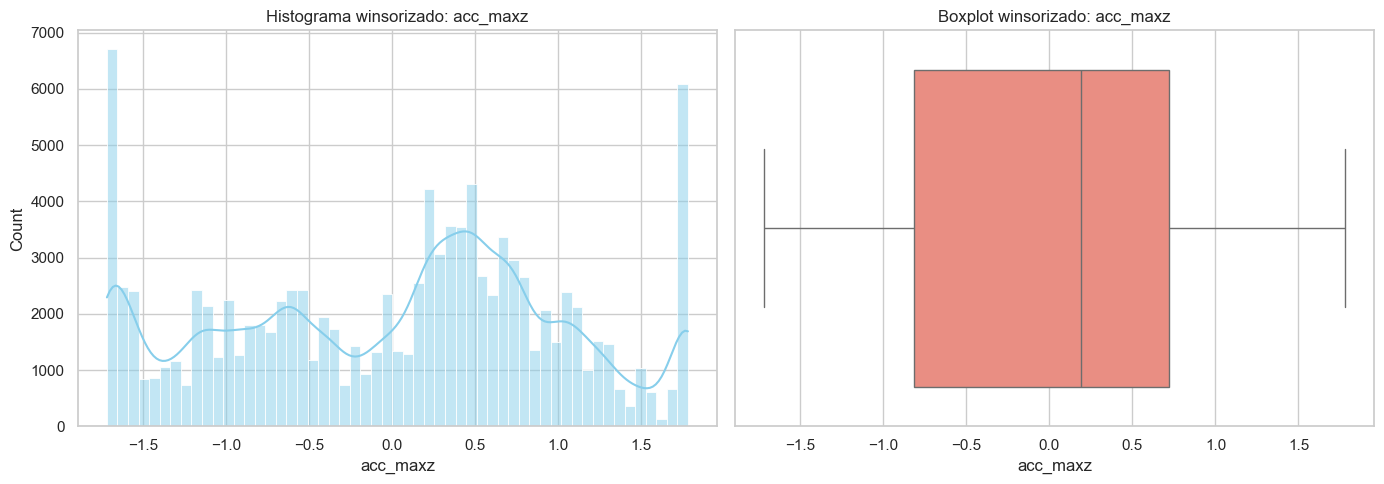


 Análisis para 'eda_max':
Media: -0.0
Mediana: -0.257
Asimetría (skewness): 0.805
Curtosis: -0.35


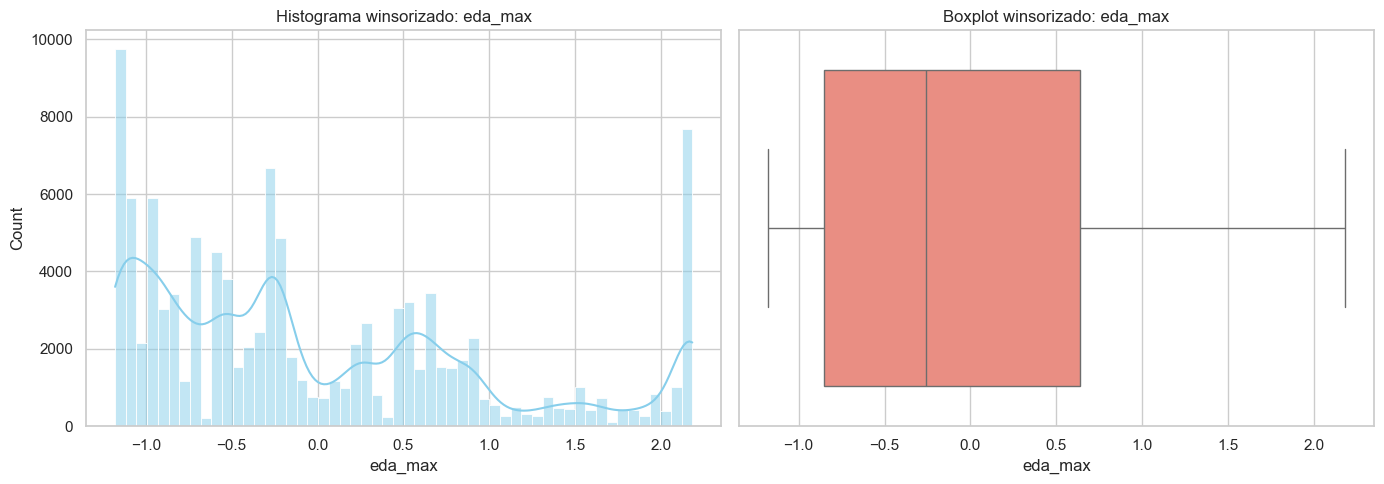


 Análisis para 'eda_min':
Media: 0.0
Mediana: -0.233
Asimetría (skewness): 0.825
Curtosis: -0.227


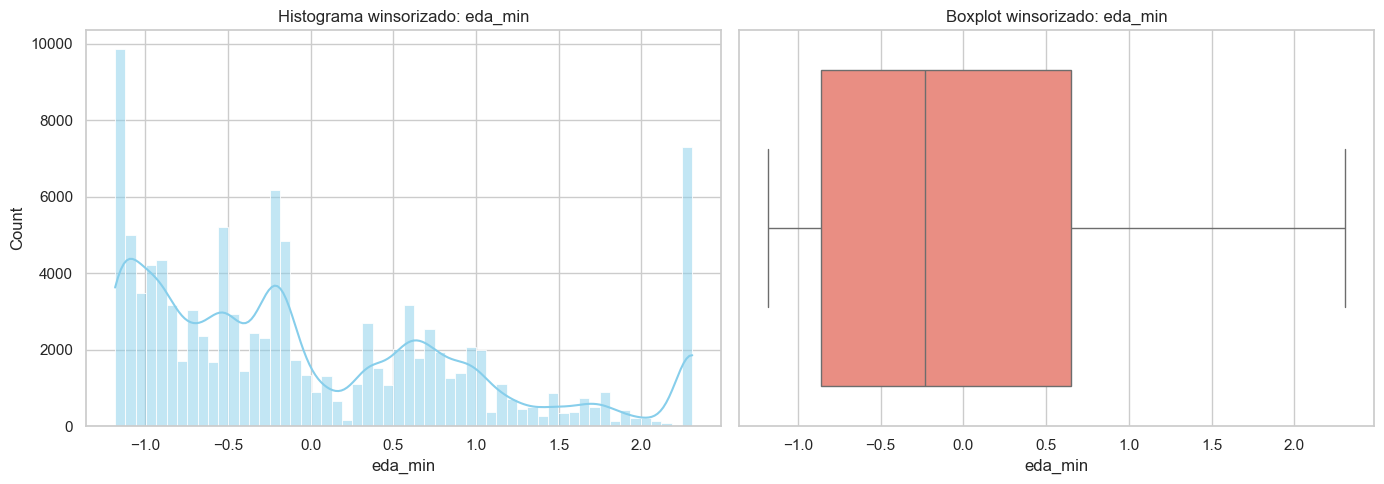


 Análisis para 'eda_mean':
Media: 0.0
Mediana: -0.242
Asimetría (skewness): 0.807
Curtosis: -0.31


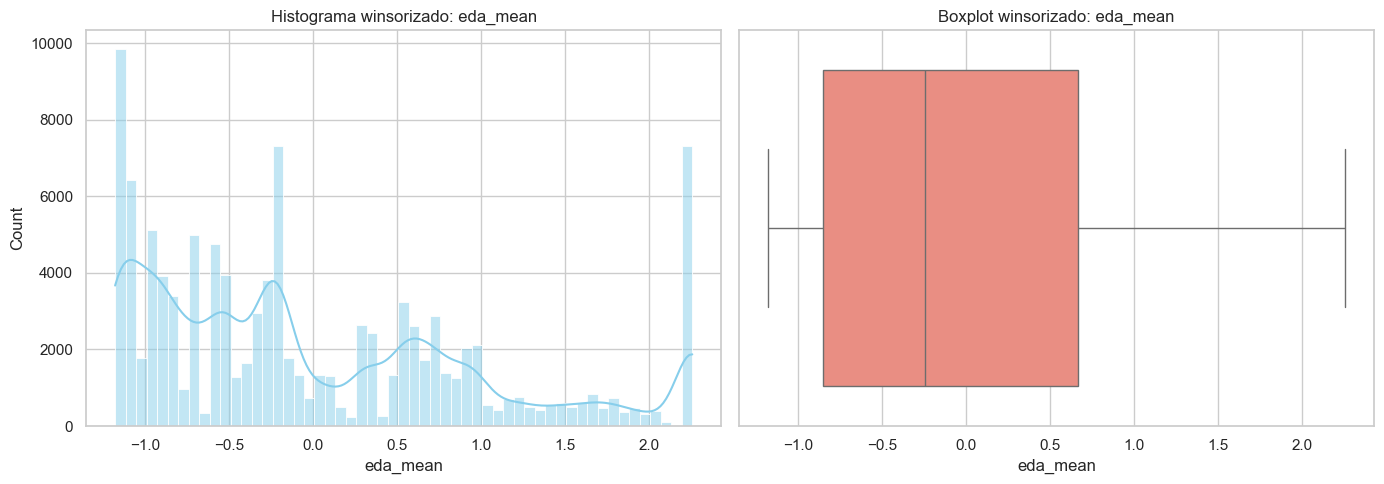


 Análisis para 'eda_range':
Media: 0.0
Mediana: -0.331
Asimetría (skewness): 1.558
Curtosis: 1.615


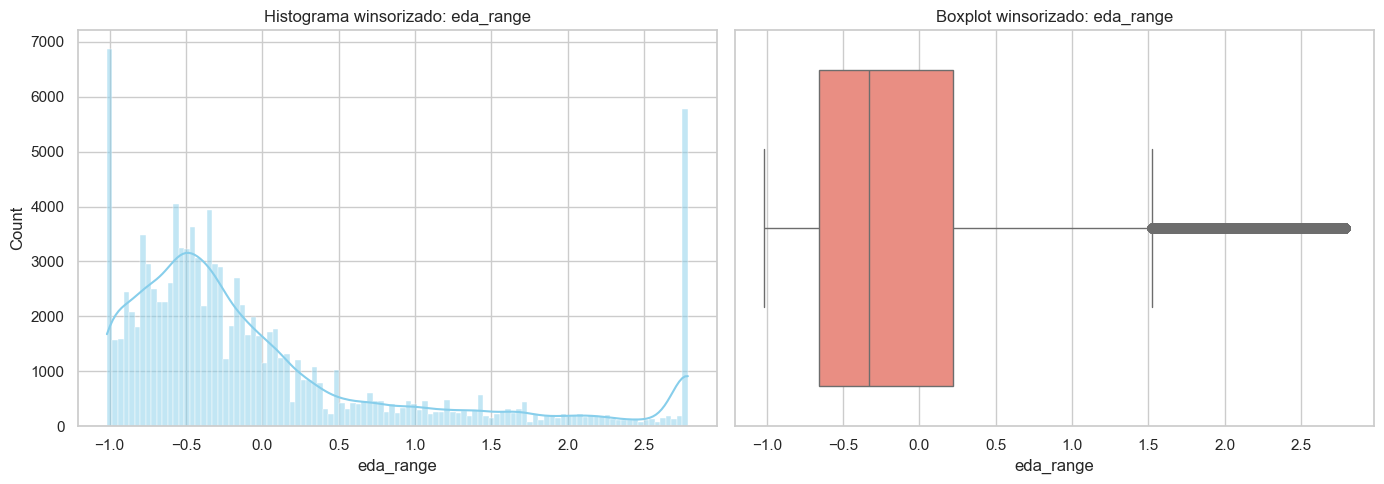


 Análisis para 'eda_std':
Media: 0.0
Mediana: -0.503
Asimetría (skewness): 1.761
Curtosis: 1.839


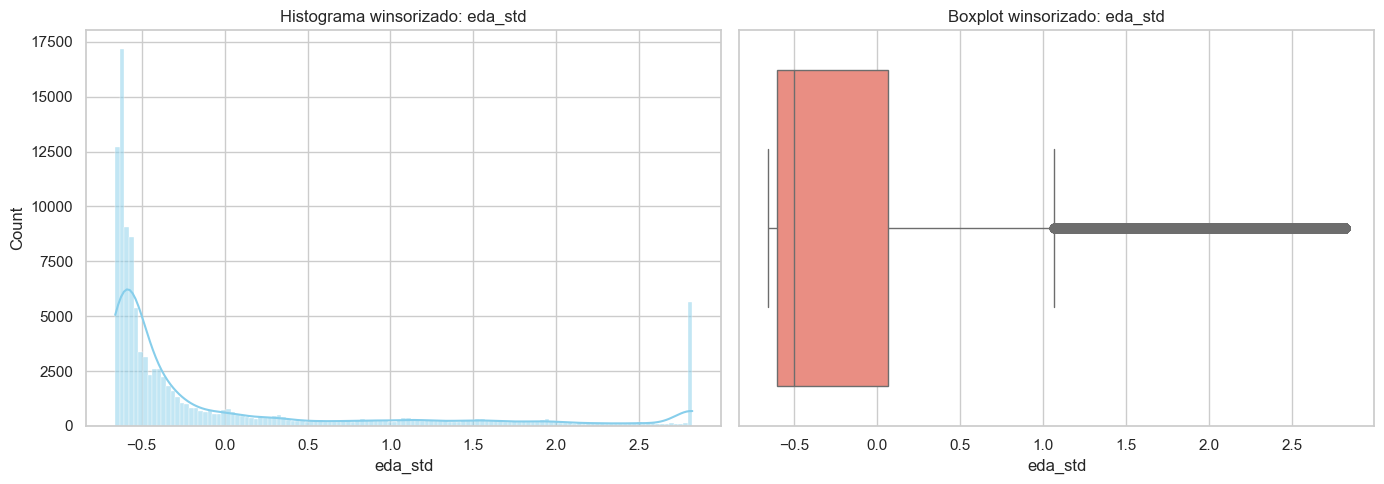


 Análisis para 'eda_slope':
Media: 0.0
Mediana: -0.021
Asimetría (skewness): 0.206
Curtosis: 1.756


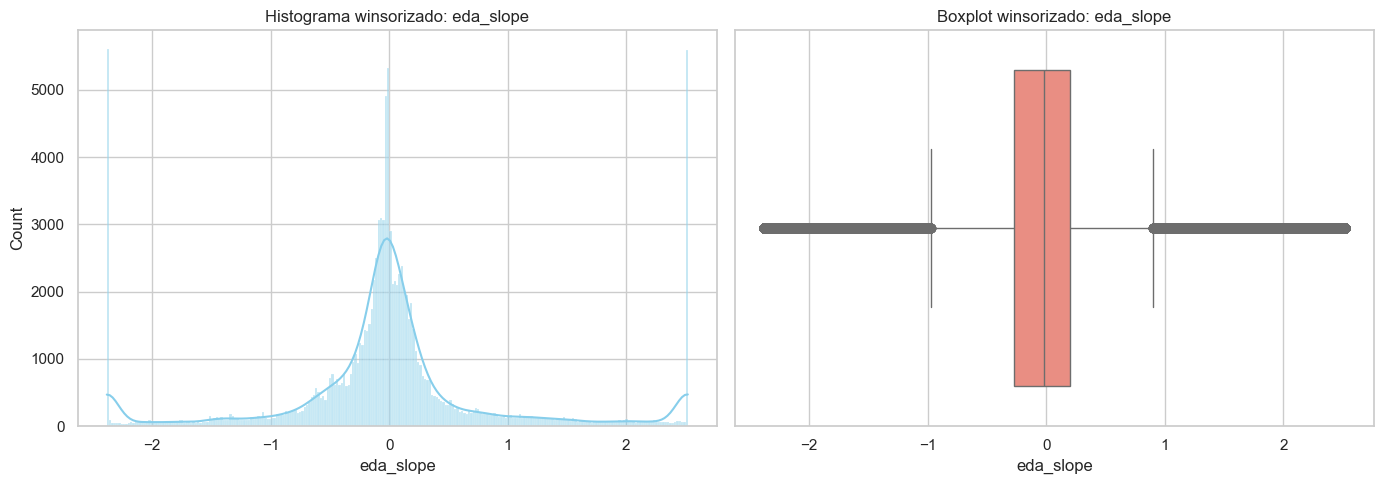

In [94]:
# Ajustes gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

for col in columns_to_winsorize:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histograma
    sns.histplot(df_winsorized[col], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Histograma winsorizado: {col}')

    # Boxplot
    sns.boxplot(x=df_winsorized[col], ax=axes[1], color='salmon')
    axes[1].set_title(f'Boxplot winsorizado: {col}')

    # Métricas
    media = round(df_winsorized[col].mean(), 3)
    mediana = round(df_winsorized[col].median(), 3)
    asimetria = round(skew(df_winsorized[col]), 3)
    curtosis = round(kurtosis(df_winsorized[col]), 3)

    print(f"\n Análisis para '{col}':")
    print(f"Media: {media}")
    print(f"Mediana: {mediana}")
    print(f"Asimetría (skewness): {asimetria}")
    print(f"Curtosis: {curtosis}")

    plt.tight_layout()
    plt.show()

Luego de aplicar la técnica de windsorización a las variables del conjunto de datos, se observa una notable reducción en la influencia de los valores extremos sobre las distribuciones de las variables numéricas. Como resultado, las variables muestran distribuciones más ajustadas, con una menor dispersión y una reducción en la asimetría. Las medidas de tendencia central, como la media, se ven menos afectadas por valores atípicos, lo que contribuye a una representación más fiel del comportamiento general de los datos. Asimismo, se preserva la estructura de los datos sin eliminar información valiosa. En términos visuales, los boxplots muestran una reducción en la longitud de los bigotes, indicando que los valores extremos fueron limitados a un límite más razonable.

# Machine Learning Model

## Modelo base

In [ ]:
# Excluir el paciente S8 de los DataFrames
df1 = df_winsorized[df_winsorized['Paciente'] != 'S8']
df = df[df['Paciente'] != 'S8']

In [ ]:
# Reemplazar label 1 y 2 con 0 y 1
df1['Label'] = df1['Label'].replace({
    1: 0,
    2: 1
})

df['Label'] = df['Label'].replace({
    1: 0,
    2: 1
})

C:\Users\mical\AppData\Local\Temp\ipykernel_11896\2456229589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Label'] = df1['Label'].replace({


In [ ]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="`sparse` was renamed to `sparse_output`",
    category=FutureWarning,
    module="sklearn.preprocessing._encoders"
)

# ------------------ DATA ------------------
cat_cols = ['Gender', 'Dominant hand']
num_cols = [c for c in df.columns if c not in cat_cols + ['Label', 'Paciente']]

X       = df[num_cols + cat_cols]
y       = df['Label'].values
groups  = df['Paciente'].values
label_names = np.unique(y)                    # e.g., array([0, 1, 2])

# ------------------ PIPELINE --------------
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

pre = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', ohe, cat_cols)
])

model = RandomForestClassifier(
    n_estimators=100,
    random_state=4,
    n_jobs=-1
)

pipe = Pipeline([
    ('prep', pre),
    ('clf', model)
])

# -------------- LOSO + CONFUSION ----------
logo       = LeaveOneGroupOut()
scores     = []
cm_global  = np.zeros((len(label_names), len(label_names)), dtype=int)

for train_idx, test_idx in logo.split(X, y, groups):
    subj = groups[test_idx][0]                 # nombre de sujeto de test
    pipe.fit(X.iloc[train_idx], y[train_idx])

    y_pred = pipe.predict(X.iloc[test_idx])
    acc    = accuracy_score(y[test_idx], y_pred)
    scores.append(acc)

    cm = confusion_matrix(y[test_idx], y_pred, labels=label_names)
    cm_global += cm

    # -------- métricas para label que nos interesa ---------
    target_label = 1  # Cambiamos a label 1 ya que solo tenemos 0 y 1
    idx_lbl = np.where(label_names == target_label)[0][0]
    tp = cm[idx_lbl, idx_lbl]
    fn = cm[idx_lbl, :].sum() - tp
    fp = cm[:, idx_lbl].sum() - tp
    tn = cm.sum() - (tp + fp + fn)

    sensibilidad = tp / (tp + fn + 1e-9)
    especificidad = tn / (tn + fp + 1e-9)

    print(f"\n─── Sujeto {subj} ──  acc={acc:.3f}")
    print(pd.DataFrame(cm,
          index=[f"real_{l}" for l in label_names],
          columns=[f"pred_{l}" for l in label_names]))
    print(f"   • Sensibilidad(label={target_label}): {sensibilidad:.3f} | "
          f"Especificidad: {especificidad:.3f}")

# ---------- Resumen global ----------------
print("\n════════ MATRIZ GLOBAL LOSO ════════")
print(pd.DataFrame(cm_global,
      index=[f"real_{l}" for l in label_names],
      columns=[f"pred_{l}" for l in label_names]))

print(f"\nMedia LOSO: {np.mean(scores):.3f} ± {np.std(scores):.3f}")


─── Sujeto S10 ──  acc=0.629
        pred_0  pred_1
real_0    4720       0
real_1    2829      71
   • Sensibilidad(label=1): 0.024 | Especificidad: 1.000

─── Sujeto S11 ──  acc=0.396
        pred_0  pred_1
real_0     224    4496
real_1       0    2720
   • Sensibilidad(label=1): 1.000 | Especificidad: 0.047

─── Sujeto S13 ──  acc=0.977
        pred_0  pred_1
real_0    4547     173
real_1       0    2656
   • Sensibilidad(label=1): 1.000 | Especificidad: 0.963

─── Sujeto S14 ──  acc=0.993
        pred_0  pred_1
real_0    4650      55
real_1       0    2700
   • Sensibilidad(label=1): 1.000 | Especificidad: 0.988

─── Sujeto S15 ──  acc=0.943
        pred_0  pred_1
real_0    4700       0
real_1     424    2320
   • Sensibilidad(label=1): 0.845 | Especificidad: 1.000

─── Sujeto S16 ──  acc=0.892
        pred_0  pred_1
real_0    4720       0
real_1     804    1888
   • Sensibilidad(label=1): 0.701 | Especificidad: 1.000

─── Sujeto S17 ──  acc=0.663
        pred_0  pred_1
real_0    4

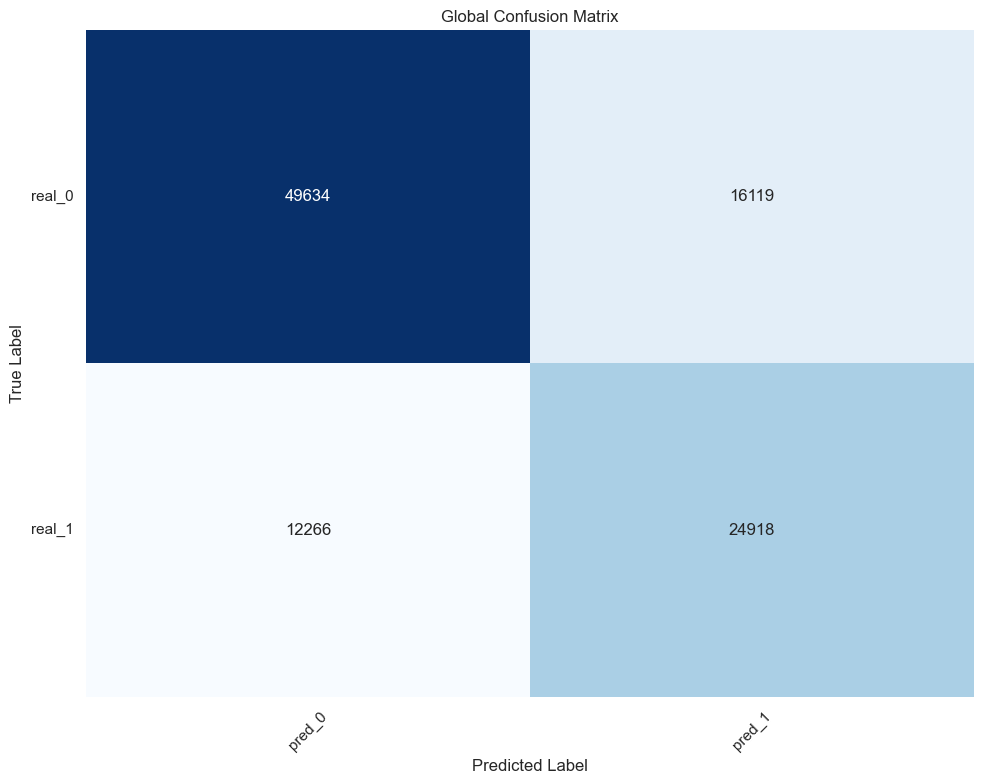

In [100]:
# Definir la matriz global
cm_global_df = pd.DataFrame(cm_global,
                             index=[f"real_{l}" for l in label_names],
                             columns=[f"pred_{l}" for l in label_names])
# Graficar la matriz de confusión global
plt.figure(figsize=(10, 8))
sns.heatmap(cm_global_df, annot=True, fmt='d', cmap='Blues', cbar=False)   
plt.title('Global Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Siguiendo la lógica de validación Leave One Subject Out (LOSO), se puede ver que, en términos generales el modelo tiene un buen desempeño. De la totalidad de los datos, el Random Forest clasifica correctamente un 72.5% con un desvío de ± 0.221, lo cual demuestra que existe variabilidad entre los pacientes y que no todos siguen un mismo patrón.
En particular, el modelo logra identificar correctamente 24.918 instancias de estrés y 49.634 de baseline, aunque también comete errores al clasificar 12.226 casos de estrés con baseline y 16.119 de baseline con estrés.

# Modelo final

La idea de este apartado es encontrar la mejor combinación de hiperparámetros para un modelo a priori, más avanzado, y luego ver cómo se comporta esa grilla con la lógica de LOSO. El modelo que se elige en esta instancia es un XGBoost Classifier.

## XGBoost: Búsqueda de la mejor grilla de hiperparámetros

In [101]:
# ------------ columnas numéricas y categóricas -----------------
cat_cols = ['Gender', 'Dominant hand']
num_cols = [c for c in df1.columns if c not in cat_cols + ['Label', 'Paciente']]

X_df   = df1[num_cols + cat_cols]
y      = df1['Label'].astype(int).values
groups = df1['Paciente'].values

# --------------------- preprocesador ----------------------------
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
pre = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', ohe, cat_cols)
])

# ---------------------------------------------------------------
# 1)  Búsqueda global de hiperparámetros (GroupKFold interno)
# ---------------------------------------------------------------
param_grid = {
    'clf__n_estimators':     [200, 400],
    'clf__learning_rate':    [0.05, 0.1],
    'clf__max_depth':        [3, 5, 7],
    'clf__subsample':        [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0]
}

pipe = Pipeline([
    ('prep', pre),
    ('clf', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False))
])

inner_cv = GroupKFold(n_splits=5)              # 5 grupos ≈ 2-3 sujetos c/u
grid_global = GridSearchCV(pipe,
                           param_grid,
                           cv=inner_cv,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

# print("Buscando la mejor grilla")
# grid_global.fit(X_df, y, groups=groups)

# best_params = grid_global.best_params_
# print("Hiperparámetros óptimos:", best_params)

In [109]:
# ------------------ PIPELINE CON MEJORES HIPERPARÁMETROS --------------
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
pre = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', ohe, cat_cols)
])  

best_params = {
    'colsample_bytree': 0.8, 
    'learning_rate': 0.1, 
    'max_depth': 7, 
    'n_estimators': 200, 
    'subsample': 1.0
}


best_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=4,
    n_jobs=-1,
    use_label_encoder=False,
    **best_params
)

pipe = Pipeline([
    ('prep', pre),
    ('clf', best_model)
])

# Validación Leave-One-Subject-Out (LOSO)
logo = LeaveOneGroupOut()
scores = []
cm_global = np.zeros((2, 2), dtype=int)

for train_idx, test_idx in logo.split(X_df, y, groups):
    subj = groups[test_idx][0]  # Nombre del sujeto de test
    pipe.fit(X_df.iloc[train_idx], y[train_idx])

    y_pred = pipe.predict(X_df.iloc[test_idx])
    acc = accuracy_score(y[test_idx], y_pred)
    scores.append(acc)

    cm = confusion_matrix(y[test_idx], y_pred, labels=[0, 1])
    cm_global += cm

    # Metricas para la etiqueta de interés (1)
    idx_lbl = 1
    #idx_lbl = np.where([0, 1] == target_label)[0][0]
    tp = cm[idx_lbl, idx_lbl]
    fn = cm[idx_lbl, :].sum() - tp
    fp = cm[:, idx_lbl].sum() - tp
    tn = cm.sum() - (tp + fp + fn)

    sensibilidad = tp / (tp + fn + 1e-9)
    especificidad = tn / (tn + fp + 1e-9)

    print(f"\n─── Sujeto {subj} ──  acc={acc:.3f}")
    print(pd.DataFrame(cm, index=['real_0', 'real_1'], columns=['pred_0', 'pred_1']))
    print(f"   • Sensibilidad(label={target_label}): {sensibilidad:.3f} | "
          f"Especificidad: {especificidad:.3f}")
    
# Resumen global
print("\n════════ MATRIZ GLOBAL LOSO ════════")
print(pd.DataFrame(cm_global, index=['real_0', 'real_1'], columns=['pred_0', 'pred_1']))
print(f"\nMedia LOSO: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

C:\Users\mical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:06:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



─── Sujeto S10 ──  acc=0.712
        pred_0  pred_1
real_0    4720       0
real_1    2193     707
   • Sensibilidad(label=1): 0.244 | Especificidad: 1.000


C:\Users\mical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:06:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



─── Sujeto S11 ──  acc=0.810
        pred_0  pred_1
real_0    3603    1117
real_1     295    2425
   • Sensibilidad(label=1): 0.892 | Especificidad: 0.763


C:\Users\mical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:06:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



─── Sujeto S13 ──  acc=0.994
        pred_0  pred_1
real_0    4675      45
real_1       0    2656
   • Sensibilidad(label=1): 1.000 | Especificidad: 0.990


C:\Users\mical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:06:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



─── Sujeto S14 ──  acc=0.806
        pred_0  pred_1
real_0    4705       0
real_1    1438    1262
   • Sensibilidad(label=1): 0.467 | Especificidad: 1.000


C:\Users\mical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:06:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



─── Sujeto S15 ──  acc=0.706
        pred_0  pred_1
real_0    4700       0
real_1    2187     557
   • Sensibilidad(label=1): 0.203 | Especificidad: 1.000


C:\Users\mical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:06:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



─── Sujeto S16 ──  acc=0.975
        pred_0  pred_1
real_0    4720       0
real_1     182    2510
   • Sensibilidad(label=1): 0.932 | Especificidad: 1.000


C:\Users\mical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:06:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



─── Sujeto S17 ──  acc=0.671
        pred_0  pred_1
real_0    4724       0
real_1    2509     383
   • Sensibilidad(label=1): 0.132 | Especificidad: 1.000


C:\Users\mical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:06:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



─── Sujeto S2 ──  acc=0.651
        pred_0  pred_1
real_0    4576       0
real_1    2454       6
   • Sensibilidad(label=1): 0.002 | Especificidad: 1.000


C:\Users\mical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:06:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



─── Sujeto S3 ──  acc=0.471
        pred_0  pred_1
real_0     897    3663
real_1     105    2455
   • Sensibilidad(label=1): 0.959 | Especificidad: 0.197


C:\Users\mical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



─── Sujeto S4 ──  acc=1.000
        pred_0  pred_1
real_0    4632       0
real_1       0    2540
   • Sensibilidad(label=1): 1.000 | Especificidad: 1.000


C:\Users\mical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:06:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



─── Sujeto S5 ──  acc=0.351
        pred_0  pred_1
real_0       6    4786
real_1       0    2580
   • Sensibilidad(label=1): 1.000 | Especificidad: 0.001


C:\Users\mical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:06:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



─── Sujeto S6 ──  acc=0.954
        pred_0  pred_1
real_0    4720       0
real_1     339    2261
   • Sensibilidad(label=1): 0.870 | Especificidad: 1.000


C:\Users\mical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:06:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



─── Sujeto S7 ──  acc=0.350
        pred_0  pred_1
real_0       0    4744
real_1       0    2560
   • Sensibilidad(label=1): 1.000 | Especificidad: 0.000


C:\Users\mical\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:06:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



─── Sujeto S9 ──  acc=0.778
        pred_0  pred_1
real_0    3432    1288
real_1     329    2251
   • Sensibilidad(label=1): 0.872 | Especificidad: 0.727

════════ MATRIZ GLOBAL LOSO ════════
        pred_0  pred_1
real_0   50110   15643
real_1   12031   25153

Media LOSO: 0.731 ± 0.213


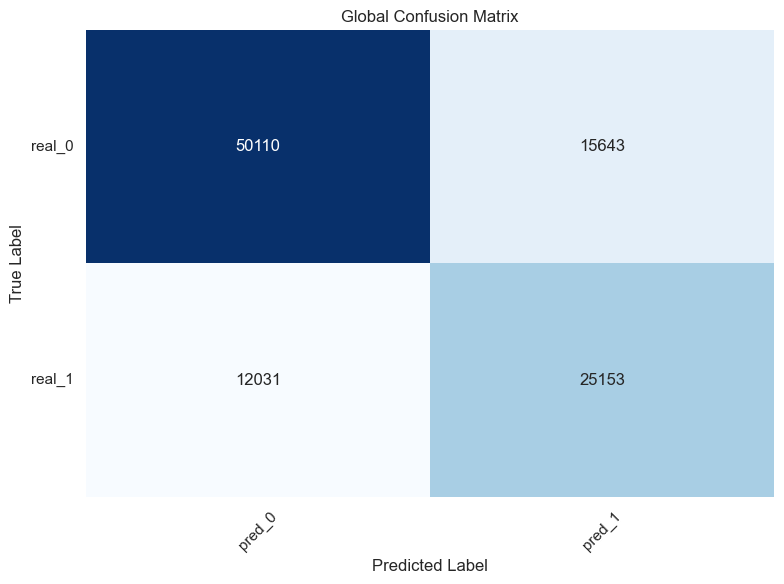

In [110]:
# Visualización de la matriz de confusión global
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(cm_global, index=['real_0', 'real_1'], columns=['pred_0', 'pred_1']),
            annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Global Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Teniendo en cuenta la misma lógica de validación Leave-One-Subject-Out (LOSO), en esta instancia se utilizó el modelo XGBoost entrenando con los mismos datos que para el modelo Random Forest. El rendimiento global del modelo muestra un accuracy promedio de 73.1% con una desviación de ± 0.213, lo cual indica un desempeño general aceptable, aunque con variabilidad entre sujetos.
La matriz de confusión global revela que el modelo clasifica correctamente 50.110 instancias de baseline (label 0) y 25.153 de estrés (label 1). No obstante, también se puede ver como 15.553 casos reales de baseline fueron clasificados como estrés, y 12.031 casos reales de estrés fueron clasificados como baseline.
Si bien el rendimiento de ambos modelos es muy siilar, el segundo modelo predice mejor los casos en donde las personas .

In [104]:
# Guardamos el modelo entrenado con pickle
with open(r"C:\Users\mical\OneDrive - UCA\UCA\2025\1er cuatrimestre\Laboratorio de datos I\FINAL FINAL\xgboost_model2.pkl", 'wb') as f:
    pickle.dump(pipe, f)